In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy import optimize

In [31]:
#change the file name to correspond to your text file location
data = np.genfromtxt('./Group Project/ASTR19_F24_group_project_data.txt', dtype=[('day', 'i8'), ('time', 'U6'), ('height', 'f8')])

#the
day = []
time = []
y = []

for i in range(82):
    #assign first, second and third columns to day, time, and height
    day.append(data[i][0])
    time.append(data[i][1])
    y.append(data[i][2])

print(day)
print('')
print(time)
print('')
print(y)

[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41]

['8:07', '15:37', '8:55', '16:25', '9:45', '17:14', '10:35', '18:00', '11:28', '18:46', '12:22', '19:31', '13:24', '20:16', '3:22', '21:01', '4:07', '21:46', '4:50', '11:58', '5:31', '12:56', '6:08', '13:45', '6:47', '14:25', '7:22', '15:00', '7:59', '15:34', '8:34', '16:08', '9:10', '16:41', '9:45', '17:12', '10:21', '17:45', '10:57', '18:15', '11:38', '18:48', '12:25', '19:20', '2:22', '19:52', '2:58', '20:30', '3:37', '10:44', '4:23', '11:55', '5:15', '12:57', '6:09', '13:50', '7:05', '14:39', '7:58', '15:27', '8:50', '16:10', '9:40', '16:52', '10:30', '17:34', '11:19', '18:12', '12:10', '18:49', '1:32', '19:24', '2:13', '20:00', '2:54', '9:54', '3:39', '11:15', '4:29', '12:22

In [32]:
percents = []
for times in time:
    hourmin = times.split(':')
    percent = (float(hourmin[0]) + float(hourmin[1])/60) /24
    percents.append(percent)
x = [percent + daynum for percent, daynum in zip(percents, day)]

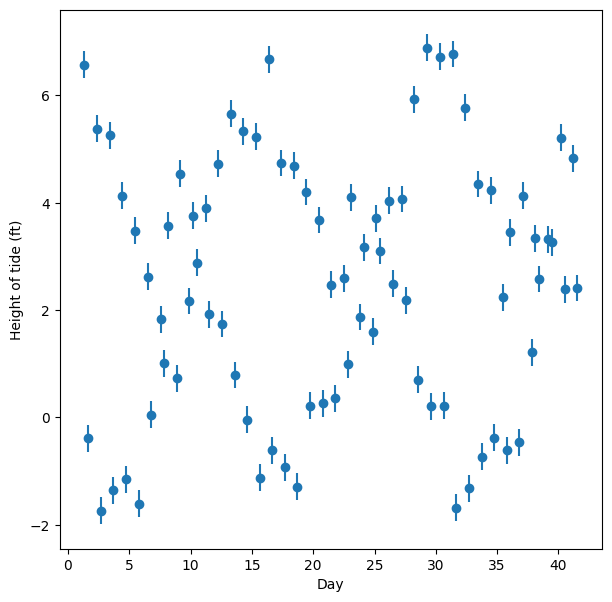

In [33]:
f = plt.figure(figsize=(7,7))
plt.errorbar(x, y, yerr=np.full(len(y), 0.25), fmt='o')
plt.xlabel('Day')
plt.ylabel('Height of tide (ft)')
plt.show()

In [34]:
#defining the ocillating model
def o_model(x, A1, f1, p1, A2, f2, p2, C):
    return (A1 * np.sin(f1 * x + p1)) + (A2 * np.sin(f2 * x + p2)) + C

In [35]:
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Amplitudes
A1_init = ((max(y) - min(y)) / 2)
A1_fit = tf.Variable(A1_init, dtype=tf.float32)

A2_init = A1_init / 2
A2_fit = tf.Variable(A2_init, dtype=tf.float32)

# Periods

f1_init = 2*np.pi
f1_fit = tf.Variable(f1_init, dtype=tf.float32)

f2_init = np.pi/15
f2_fit = tf.Variable(f2_init, dtype=tf.float32)

# Phases

p1_init = 0
p1_fit = tf.Variable(p1_init, dtype=tf.float32)

p2_init = 2
p2_fit = tf.Variable(p2_init, dtype=tf.float32)

# Offset

C_init = np.mean(y)
C_fit = tf.Variable(C_init, dtype=tf.float32)

In [36]:
@tf.function
def f_tide(x):
    """A more complex tidal model function."""
    return (A1_fit * tf.math.sin(f1_fit * x + p1_fit)) + (A2_fit * tf.math.sin(f2_fit * x + p2_fit)) + C_fit

In [37]:
@tf.function
def loss_function(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)

In [38]:
# Define the optimizer (Adam optimizer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [39]:
# Training loop
epochs = 5000
display_step = 1000

for epoch in range(epochs):
    if ((epoch % display_step) == 0):
        pred = f_tide(x)
        loss = loss_function(pred, y)
        print(f"Epoch {epoch} | Loss = {loss.numpy()}, A1: {A1_fit.numpy()}, f1: {f1_fit.numpy()}, p1: {p1_fit.numpy()}, A2: {A2_fit.numpy()}, f2: {f2_fit.numpy()}, p2: {p2_fit.numpy()}, C: {C_fit.numpy()}")

    with tf.GradientTape() as tape:
        pred = f_tide(x)
        loss = loss_function(pred, y)

    gradients = tape.gradient(loss, [A1_fit, f1_fit, p1_fit, A2_fit, f2_fit, p2_fit, C_fit])
    optimizer.apply_gradients(zip(gradients, [A1_fit, f1_fit, p1_fit, A2_fit, f2_fit, p2_fit, C_fit]))


print(f"Epoch {epoch} | Loss = {loss.numpy()}, A1: {A1_fit.numpy()}, f1: {f1_fit.numpy()}, p1: {p1_fit.numpy()}, A2: {A2_fit.numpy()}, f2: {f2_fit.numpy()}, p2: {p2_fit.numpy()}, C: {C_fit.numpy()}")
print('Done!')

Epoch 0 | Loss = 3.518524646759033, A1: 4.315000057220459, f1: 6.2831854820251465, p1: 0.0, A2: 2.1575000286102295, f2: 0.20943951606750488, p2: 2.0, C: 2.47829270362854
Epoch 1000 | Loss = 1.4831981658935547, A1: 3.4993343353271484, f1: 6.285391330718994, p1: -0.14473144710063934, A2: 1.2791186571121216, f2: 0.1945299208164215, p2: 2.3439781665802, C: 2.51254940032959
Epoch 2000 | Loss = 0.9228545427322388, A1: 3.089280605316162, f1: 6.284207344055176, p1: -0.11885911971330643, A2: 0.6499865055084229, f2: 0.19536830484867096, p2: 2.482611656188965, C: 2.5085673332214355
Epoch 3000 | Loss = 0.8253577351570129, A1: 2.983553171157837, f1: 6.283234119415283, p1: -0.10098108649253845, A2: 0.3011413514614105, f2: 0.19897907972335815, p2: 2.562152862548828, C: 2.4921786785125732
Epoch 4000 | Loss = 0.8190188407897949, A1: 2.9727535247802734, f1: 6.2829484939575195, p1: -0.09670595079660416, A2: 0.19461287558078766, f2: 0.20048439502716064, p2: 2.5868425369262695, C: 2.482290029525757
Epoch 4

In [40]:
x_model = np.sort(x)
y_model = o_model(x_model, A1_fit, f1_fit, p1_fit, A2_fit, f2_fit, p2_fit, C_fit)

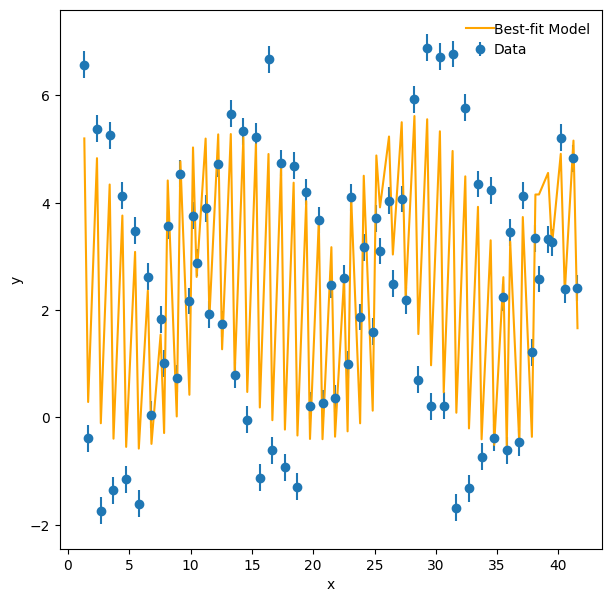

In [41]:
#plotting the 
f,ax = plt.subplots(1,1,figsize=(7,7))
ax.errorbar(x, y, yerr=np.full(len(x), 0.25), fmt='o', label='Data')
ax.plot(x_model, y_model, color='orange',label='Best-fit Model')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(frameon=False,handletextpad=0)

In [42]:
#finding the residuals
idx_model = np.argsort(x)
y_data = y[idx_model]
y_model = o_model(x[idx_model], A1_fit, f1_fit, p1_fit, A2_fit, f2_fit, p2_fit, C_fit)

residuals = y_data - y_model
residuals = residuals.numpy()

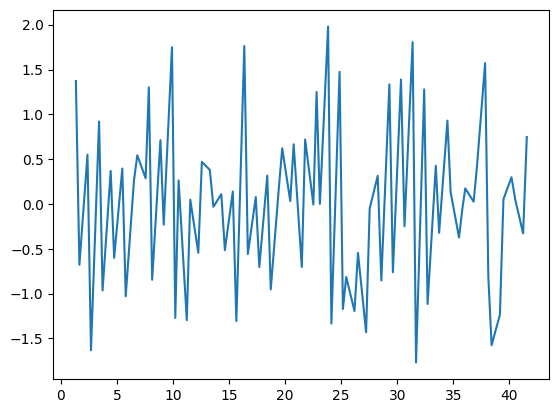

In [46]:
plt.plot(x, residuals)

In [43]:
residual_mean = np.mean(residuals)
print(f"Mean residual is {residual_mean}")
print(f"RMS residual is {residual_std}")

Mean residual is -7.27322048987844e-06
RMS residual is 0.904962956905365


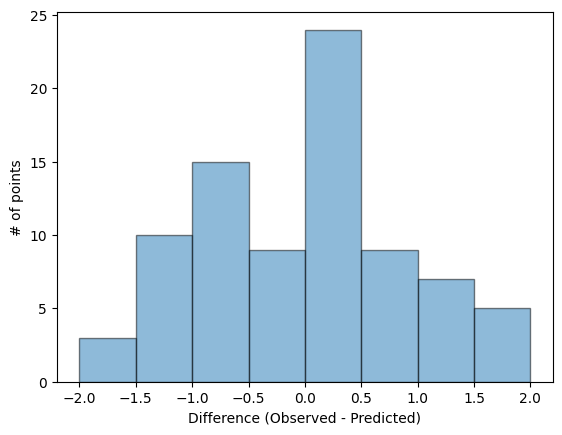

In [44]:
width = 0.5
histmin = np.floor(min(residuals))
histmax = np.ceil(max(residuals)) + width
bins = np.arange(histmin, histmax, width)
plt.hist(residuals, bins=bins, alpha=0.5, edgecolor='black')
plt.xlabel('Difference (Observed - Predicted)')
plt.ylabel('# of points')
plt.show()

In [ ]:
residual_std = np.std(residuals)
print(f"The standard deviation of the residuals is {residual_std}")